In [1]:
from IPython.display import display
import PIL 
import keras
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, BatchNormalization, GRU
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
df = pd.read_csv('original_full_data_2.csv')
mmdf = pd.read_csv('bloomberg_map_index_20200318.csv', index_col = 0)

In [3]:
df.head()

,date,GDPCQOQIndex,GDPCYOYIndex,GDPCTOTIndex,GPDITOCIndex,GPGSTOCIndex,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,...,g16,g32,g64,g128,avg,avg_four,ssd_price,flash_price,option_bit,future_bit
0,1981.1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981.1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981.1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981.1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981.1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.loc[9132 :, :]

In [5]:
len(df)

5051

In [6]:
df.reset_index(inplace = True, drop = True)

In [7]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = ((self.df[target_column] / self.df[target_column].shift(periods = self.target_day, axis = 0))-1).shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = (self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0))-1 # 여기에 1을 뺀걸 추가하면 되는거아닌가? 1.얼만에서 1이 빠진거니까

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [8]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

In [9]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [10]:
# fillna cubic -> ffill -> bfill

df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [11]:
df.isna().sum().sum()

0

In [12]:
cla = Builder(df, mmdf, 260)

In [13]:
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOTIndex,GPDITOCIndex,GPGSTOCIndex,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,...,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.988696,0.869484,3.268112,0.911087,0.984864,0.598464,0.436636,1.103782,1.596400,-4.887075
2019-10-29,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,1.023202,0.493114,1.174228,0.410159,1.089446,0.832789,1.231150,1.131356,1.864625,2.523049


In [14]:
df = cla.df.fillna(method = 'ffill').fillna(method = 'bfill')

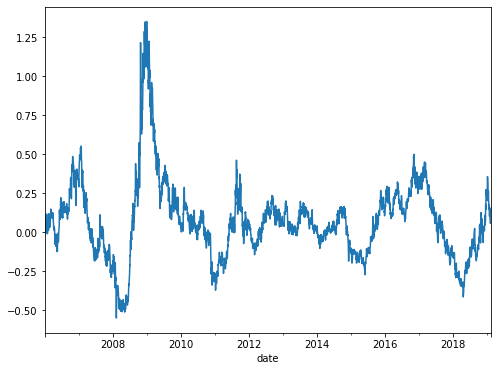

In [17]:
df['KRXsemiconductor_close'].plot()

In [16]:
df = df[0:4791]

In [18]:
df.reset_index(inplace = True)

In [19]:
len(df)

4791

In [20]:
len(df.columns)

1139

In [22]:
# 전 변수 쓰는 것으로 . 그래서 feaature는 그대로 
feature_considered = ['OEKRKLARIndex1', 'SKLIWNRSIndex260', 'MediaTek_close', 'TokyoElectron_close', 'SKLIEMPPIndex260', 'KOBONTLIndex260', 'SKLISVCIIndex60', 'KOUETTYIndex', 'KOQEEYOYIndex', 'FRNTTOTLIndex', 'KOFETOTIndex1', 'CONSSENTIndex60', 'GDPCPCECIndex', 'SKLIIMPTIndex1', 'LEIAVGWIndex120', 'KOBPCBIndex20', 'pbr', 'KOWDRIndex1', 'PCEDEFYIndex', 'CPMINEXOIndex20', 'NAPMNMIIndex20', 'NAPMNMIIndex1', 'EMPRGBCIIndex120', 'KOSPI200_change', 'SKLICONTIndex20', 'CPMINDXIndex20', 'CHALYOYIndex', 'KOEXTOTIndex260', 'KOWDRIndex60', 'SKLISVCIIndex120', 'SKLILCIndex1', 'KOBPCBIndex5', 'CICRTOTIndex1', 'USEMNCHGIndex', 'Nuvoton_change', 'KOBPCBIndex1', 'USTBEXPIndex260', 'EMPRGBCIIndex20', 'CHPMINDXIndex20', 'JOLTSEPSIndex', 'CNCILIIndex20', 'CNCILIIndex1', 'CNCILIIndex5', 'OUTFGAFIndex1', 'AWHTOTLIndex1', 'KOIPMYIndex', 'Intel_change', 'Amazon_product', 'PIDSPINXIndex60', 'AppliedMaterials_product', 'APPLE_change', 'ISECloudComputingIndex_change', 'ShinEtsuChemical_volume', 'QCOM_change', 'INJCJCIndex5', 'KOCGCGYIndex', 'Amazon_change', 'SKLINEIndex1', 'LEIACEIndex120', 'SKhynix_change', 'UMC_change', 'HPE_product', 'Google_change', 'TokyoElectron_product', 'CFNAIIndex5', 'CFNAIIndex20']
target_considered = ['KRXsemiconductor_close']

In [23]:
features = df[feature_considered]
targets = df[target_considered]

In [24]:
#features = df.drop(['date', 'KRXsemiconductor_change'], axis = 1)

In [25]:
features.index = df['date']
targets.index = df['date']

In [26]:
len(features.columns)

66

In [27]:
#features.drop(['KRXsemiconductor_close', 'KRXsemiconductor_volume','SamsungElectronics_product'], axis =1 , inplace = True)

In [28]:
col_name = features.columns
dataset = StandardScaler().fit_transform(features)# Standard Scaler , drop Samsung electronics product
dataset = pd.DataFrame(dataset, columns = col_name)

In [29]:
X_data = dataset

In [30]:
y_target = targets

In [31]:
len(X_data), len(y_target)

(4791, 4791)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [33]:
X_train = X_train.values

In [34]:
y_train = y_train.values

In [35]:
X_test = X_test.values

In [36]:
y_test = y_test.values

In [37]:
dataset.shape

(4791, 66)

In [38]:
X_train.shape

(3832, 66)

In [39]:
# Begas Custom Loss Function
def customLoss(y_true, y_pred):
    mean_true = tf.math.reduce_mean(y_true)
    mean_pred = tf.math.reduce_mean(y_pred)
    
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)
    
    up = tf.reduce_mean(tf.math.multiply((y_true-mean_true), (y_pred-mean_pred)))
    down = std_true * std_pred
    corr = 1.0-tf.compat.v1.where(tf.math.is_nan(up/down),0.0,up/down)
    
    
    meanerr = tf.math.sqrt(tf.math.square(mean_true - mean_pred))
    mserr = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_true-y_pred)))
    signerr = 1-tf.math.reduce_mean(tf.math.multiply(tf.math.sign(y_true), tf.math.sign(y_pred)))
    
    return mserr + corr/2 + signerr/2

In [40]:
X_train_t = X_train.reshape(X_train.shape[0], 66, 1)
X_test_t = X_test.reshape(X_test.shape[0], 66, 1)

In [43]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Flatten

import optuna
from optuna.integration import KerasPruningCallback

BATCHSIZE = 128
EPOCHS = 20

K.clear_session()

def create_model(trial):
    # We optimize the number of layers, hidden units and dropout in each layer and
    # the learning rate of RMSProp optimizer.

    # We define our MLP.
    n_layers = trial.suggest_int('n_layers', 1, 3) # 이게 문제인거 같은데 . 
    model = Sequential(name = 'KRXSemicondoctor_regressor')
    
    model.add(GRU(64, input_shape = (66, 1), return_sequences = True, name = 'input'))
    
    for i in range(n_layers): # n_layer에서 iter. trial은 뭐야 trial 입력에서 suggest_int는 또 뭔데 
        num_hidden = int(trial.suggest_loguniform('n_units_l{}'.format(i), 4, 128)) # 여기서 노드 수 범위 설정
        dropout = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5) # drop out 범위 설정
        
        model.add(GRU(num_hidden, return_sequences = True))
        model.add(Dropout(rate=dropout))
        model.add(BatchNormalization())
        
    model.add(Flatten())
    
    model.add(Dense(1, activation = 'linear', name = 'output',
                   kernel_regularizer=keras.regularizers.l2(l=0.3)))

    # We compile our model with a sampled learning rate.
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) # 이건 범위니까 그대로 놔둬도 되고
    
    model.compile(loss='mse',
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=['mse'])

    return model


def objective(trial):
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()

    # Generate our trial model.
    model = create_model(trial)

    # Fit the model on the training data.
    # The KerasPruningCallback checks for pruning condition every epoch.
    
    model.fit(X_train_t,
              y_train,
              batch_size=BATCHSIZE,
              callbacks=[KerasPruningCallback(trial, 'val_loss')],
              epochs=EPOCHS,
              validation_data=(X_test_t, y_test),
              verbose=1)

    # Evaluate the model accuracy on the test set.
    score = model.evaluate(X_test_t, y_test, verbose=0)
    return score[1]

In [44]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)
pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial

print('  Value: ', trial.value)

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 54s - loss: 2.4084 - mse: 1.79 - ETA: 29s - loss: 13.3379 - mse: 12.60 - ETA: 20s - loss: 11.2962 - mse: 10.46 - ETA: 16s - loss: 18.8319 - mse: 17.86 - ETA: 13s - loss: 18.1309 - mse: 17.06 - ETA: 11s - loss: 16.1320 - mse: 14.99 - ETA: 10s - loss: 14.7603 - mse: 13.55 - ETA: 9s - loss: 13.9741 - mse: 12.6945 - ETA: 8s - loss: 13.9144 - mse: 12.568 - ETA: 7s - loss: 16.4329 - mse: 15.024 - ETA: 6s - loss: 16.2117 - mse: 14.750 - ETA: 6s - loss: 15.4924 - mse: 13.981 - ETA: 5s - loss: 17.7842 - mse: 16.225 - ETA: 5s - loss: 17.4798 - mse: 15.881 - ETA: 4s - loss: 16.8954 - mse: 15.263 - ETA: 4s - loss: 16.9568 - mse: 15.295 - ETA: 3s - loss: 16.7851 - mse: 15.098 - ETA: 3s - loss: 16.2966 - mse: 14.589 - ETA: 3s - loss: 15.7416 - mse: 14.016 - ETA: 2s - loss: 15.2550 - mse: 13.514 - ETA: 2s - loss: 14.8320 - mse: 13.078 - ETA: 2s - loss: 14.3804 - mse: 12.614 - ETA: 1s - loss: 14

[I 2020-03-18 20:42:14,270] Finished trial#0 resulted in value: 0.06284265220165253. Current best value is 0.06284265220165253 with parameters: {'n_layers': 3, 'n_units_l0': 4.957129244336615, 'dropout_l0': 0.2641796271765938, 'n_units_l1': 18.22730575463474, 'dropout_l1': 0.25759867806361403, 'n_units_l2': 12.676854524286334, 'dropout_l2': 0.24179233662037067, 'lr': 0.049662376660186656}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 21s - loss: 2.2573 - mse: 1.70 - ETA: 11s - loss: 2.0751 - mse: 1.52 - ETA: 8s - loss: 2.2591 - mse: 1.7074 - ETA: 6s - loss: 2.1372 - mse: 1.585 - ETA: 5s - loss: 2.0756 - mse: 1.524 - ETA: 4s - loss: 2.0512 - mse: 1.499 - ETA: 4s - loss: 2.0516 - mse: 1.500 - ETA: 3s - loss: 2.0739 - mse: 1.522 - ETA: 3s - loss: 2.0799 - mse: 1.528 - ETA: 3s - loss: 2.0641 - mse: 1.512 - ETA: 3s - loss: 2.1009 - mse: 1.549 - ETA: 2s - loss: 2.0891 - mse: 1.538 - ETA: 2s - loss: 2.0848 - mse: 1.533 - ETA: 2s - loss: 2.0846 - mse: 1.533 - ETA: 2s - loss: 2.0717 - mse: 1.520 - ETA: 1s - loss: 2.0803 - mse: 1.529 - ETA: 1s - loss: 2.0528 - mse: 1.502 - ETA: 1s - loss: 2.0490 - mse: 1.498 - ETA: 1s - loss: 2.0384 - mse: 1.487 - ETA: 1s - loss: 2.0248 - mse: 1.474 - ETA: 1s - loss: 2.0205 - mse: 1.470 - ETA: 1s - loss: 2.0238 - mse: 1.473 - ETA: 0s - loss: 2.0169 - mse: 1.466 - ETA: 0s - loss: 2.0109

[I 2020-03-18 20:43:26,514] Finished trial#1 resulted in value: 0.10082505643367767. Current best value is 0.10082505643367767 with parameters: {'n_layers': 1, 'n_units_l0': 5.930531088075911, 'dropout_l0': 0.48068445834579754, 'lr': 3.917022200014826e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 35s - loss: 2.7107 - mse: 2.08 - ETA: 19s - loss: 2.4337 - mse: 1.83 - ETA: 13s - loss: 2.8202 - mse: 2.24 - ETA: 11s - loss: 2.7572 - mse: 2.20 - ETA: 9s - loss: 2.4781 - mse: 1.9492 - ETA: 8s - loss: 2.3231 - mse: 1.816 - ETA: 7s - loss: 2.1595 - mse: 1.674 - ETA: 6s - loss: 2.0216 - mse: 1.556 - ETA: 5s - loss: 1.8957 - mse: 1.448 - ETA: 5s - loss: 1.8019 - mse: 1.370 - ETA: 4s - loss: 1.6984 - mse: 1.281 - ETA: 4s - loss: 1.6352 - mse: 1.232 - ETA: 4s - loss: 1.5529 - mse: 1.162 - ETA: 3s - loss: 1.4902 - mse: 1.112 - ETA: 3s - loss: 1.4288 - mse: 1.062 - ETA: 3s - loss: 1.3731 - mse: 1.017 - ETA: 2s - loss: 1.3243 - mse: 0.978 - ETA: 2s - loss: 1.2724 - mse: 0.936 - ETA: 2s - loss: 1.2308 - mse: 0.904 - ETA: 2s - loss: 1.1891 - mse: 0.871 - ETA: 1s - loss: 1.1440 - mse: 0.835 - ETA: 1s - loss: 1.1113 - mse: 0.811 - ETA: 1s - loss: 1.0744 - mse: 0.782 - ETA: 1s - loss: 1.0388

[I 2020-03-18 20:45:20,278] Finished trial#2 resulted in value: 0.1053989976644516. Current best value is 0.1053989976644516 with parameters: {'n_layers': 2, 'n_units_l0': 27.62265143750615, 'dropout_l0': 0.391289364165978, 'n_units_l1': 5.79883996261852, 'dropout_l1': 0.29002692238899436, 'lr': 0.03797286990803407}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 22s - loss: 2.0704 - mse: 1.48 - ETA: 12s - loss: 4.1862 - mse: 3.60 - ETA: 9s - loss: 3.4512 - mse: 2.8700 - ETA: 7s - loss: 3.2046 - mse: 2.626 - ETA: 6s - loss: 2.8793 - mse: 2.304 - ETA: 5s - loss: 2.7118 - mse: 2.139 - ETA: 4s - loss: 2.6216 - mse: 2.052 - ETA: 4s - loss: 2.4831 - mse: 1.916 - ETA: 3s - loss: 2.3639 - mse: 1.801 - ETA: 3s - loss: 2.2465 - mse: 1.686 - ETA: 3s - loss: 2.1715 - mse: 1.615 - ETA: 2s - loss: 2.0910 - mse: 1.538 - ETA: 2s - loss: 2.0293 - mse: 1.480 - ETA: 2s - loss: 1.9592 - mse: 1.414 - ETA: 2s - loss: 1.8960 - mse: 1.355 - ETA: 2s - loss: 1.8529 - mse: 1.316 - ETA: 1s - loss: 1.7962 - mse: 1.264 - ETA: 1s - loss: 1.7506 - mse: 1.223 - ETA: 1s - loss: 1.7053 - mse: 1.182 - ETA: 1s - loss: 1.6596 - mse: 1.141 - ETA: 1s - loss: 1.6220 - mse: 1.108 - ETA: 1s - loss: 1.5937 - mse: 1.085 - ETA: 0s - loss: 1.5601 - mse: 1.056 - ETA: 0s - loss: 1.5229

[I 2020-03-18 20:46:35,630] Finished trial#3 resulted in value: 0.03537651151418686. Current best value is 0.1053989976644516 with parameters: {'n_layers': 2, 'n_units_l0': 27.62265143750615, 'dropout_l0': 0.391289364165978, 'n_units_l1': 5.79883996261852, 'dropout_l1': 0.29002692238899436, 'lr': 0.03797286990803407}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 52s - loss: 3.1879 - mse: 2.59 - ETA: 28s - loss: 3.0506 - mse: 2.45 - ETA: 20s - loss: 2.8432 - mse: 2.24 - ETA: 15s - loss: 2.6571 - mse: 2.06 - ETA: 13s - loss: 2.5438 - mse: 1.95 - ETA: 11s - loss: 2.4345 - mse: 1.84 - ETA: 10s - loss: 2.3388 - mse: 1.75 - ETA: 9s - loss: 2.3008 - mse: 1.7149 - ETA: 8s - loss: 2.2413 - mse: 1.657 - ETA: 7s - loss: 2.2131 - mse: 1.630 - ETA: 6s - loss: 2.1923 - mse: 1.611 - ETA: 6s - loss: 2.1641 - mse: 1.584 - ETA: 5s - loss: 2.1519 - mse: 1.574 - ETA: 5s - loss: 2.1329 - mse: 1.556 - ETA: 4s - loss: 2.1094 - mse: 1.534 - ETA: 4s - loss: 2.0990 - mse: 1.526 - ETA: 3s - loss: 2.0812 - mse: 1.510 - ETA: 3s - loss: 2.0751 - mse: 1.505 - ETA: 3s - loss: 2.0538 - mse: 1.485 - ETA: 2s - loss: 2.0290 - mse: 1.462 - ETA: 2s - loss: 2.0051 - mse: 1.440 - ETA: 2s - loss: 1.9855 - mse: 1.422 - ETA: 1s - loss: 1.9604 - mse: 1.399 - ETA: 1s - loss: 1.9411

[I 2020-03-18 20:49:10,748] Finished trial#4 resulted in value: 0.033282339572906494. Current best value is 0.1053989976644516 with parameters: {'n_layers': 2, 'n_units_l0': 27.62265143750615, 'dropout_l0': 0.391289364165978, 'n_units_l1': 5.79883996261852, 'dropout_l1': 0.29002692238899436, 'lr': 0.03797286990803407}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 50s - loss: 1.8343 - mse: 1.26 - ETA: 27s - loss: 2.0220 - mse: 1.45 - ETA: 19s - loss: 2.0537 - mse: 1.48 - ETA: 15s - loss: 2.0060 - mse: 1.43 - ETA: 12s - loss: 2.0763 - mse: 1.50 - ETA: 10s - loss: 2.1164 - mse: 1.54 - ETA: 9s - loss: 2.0649 - mse: 1.4941 - ETA: 8s - loss: 2.0551 - mse: 1.484 - ETA: 7s - loss: 2.0451 - mse: 1.474 - ETA: 7s - loss: 2.0179 - mse: 1.447 - ETA: 6s - loss: 1.9868 - mse: 1.416 - ETA: 6s - loss: 1.9942 - mse: 1.423 - ETA: 5s - loss: 1.9926 - mse: 1.422 - ETA: 5s - loss: 1.9947 - mse: 1.424 - ETA: 4s - loss: 1.9864 - mse: 1.416 - ETA: 4s - loss: 1.9645 - mse: 1.394 - ETA: 3s - loss: 1.9430 - mse: 1.373 - ETA: 3s - loss: 1.9426 - mse: 1.372 - ETA: 3s - loss: 1.9658 - mse: 1.396 - ETA: 2s - loss: 1.9565 - mse: 1.386 - ETA: 2s - loss: 1.9640 - mse: 1.394 - ETA: 2s - loss: 1.9510 - mse: 1.381 - ETA: 1s - loss: 1.9417 - mse: 1.372 - ETA: 1s - loss: 1.9438

[I 2020-03-18 20:51:45,690] Finished trial#5 resulted in value: 0.16745057702064514. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 22s - loss: 1.2322 - mse: 0.61 - ETA: 12s - loss: 23.9512 - mse: 21.91 - ETA: 8s - loss: 85.7896 - mse: 82.8425 - ETA: 6s - loss: 76.0153 - mse: 72.432 - ETA: 5s - loss: 66.5365 - mse: 62.209 - ETA: 5s - loss: 61.2653 - mse: 56.049 - ETA: 4s - loss: 59.4970 - mse: 53.281 - ETA: 4s - loss: 56.7179 - mse: 49.464 - ETA: 3s - loss: 55.9043 - mse: 47.603 - ETA: 3s - loss: 54.3276 - mse: 45.002 - ETA: 3s - loss: 53.5439 - mse: 43.235 - ETA: 2s - loss: 52.7056 - mse: 41.470 - ETA: 2s - loss: 51.8528 - mse: 39.757 - ETA: 2s - loss: 51.2082 - mse: 38.321 - ETA: 2s - loss: 50.4169 - mse: 36.813 - ETA: 2s - loss: 49.7121 - mse: 35.466 - ETA: 1s - loss: 48.7909 - mse: 33.975 - ETA: 1s - loss: 47.7696 - mse: 32.454 - ETA: 1s - loss: 46.7153 - mse: 30.967 - ETA: 1s - loss: 45.8216 - mse: 29.702 - ETA: 1s - loss: 44.9201 - mse: 28.487 - ETA: 1s - loss: 44.0504 - mse: 27.357 - ETA: 0s - loss: 43

[I 2020-03-18 20:53:00,019] Finished trial#6 resulted in value: 0.04224053770303726. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 50s - loss: 3.3092 - mse: 2.70 - ETA: 27s - loss: 2.8297 - mse: 2.23 - ETA: 19s - loss: 2.6452 - mse: 2.05 - ETA: 15s - loss: 2.5926 - mse: 2.00 - ETA: 12s - loss: 2.4813 - mse: 1.89 - ETA: 11s - loss: 2.4328 - mse: 1.84 - ETA: 9s - loss: 2.3768 - mse: 1.7970 - ETA: 8s - loss: 2.3097 - mse: 1.733 - ETA: 7s - loss: 2.2492 - mse: 1.677 - ETA: 7s - loss: 2.2022 - mse: 1.634 - ETA: 6s - loss: 2.1544 - mse: 1.590 - ETA: 6s - loss: 2.1340 - mse: 1.573 - ETA: 5s - loss: 2.0946 - mse: 1.538 - ETA: 5s - loss: 2.0709 - mse: 1.518 - ETA: 4s - loss: 2.0338 - mse: 1.485 - ETA: 4s - loss: 1.9985 - mse: 1.454 - ETA: 3s - loss: 1.9568 - mse: 1.416 - ETA: 3s - loss: 1.9269 - mse: 1.390 - ETA: 3s - loss: 1.8952 - mse: 1.363 - ETA: 2s - loss: 1.8715 - mse: 1.343 - ETA: 2s - loss: 1.8485 - mse: 1.324 - ETA: 2s - loss: 1.8242 - mse: 1.304 - ETA: 1s - loss: 1.7960 - mse: 1.279 - ETA: 1s - loss: 1.7772

[I 2020-03-18 20:53:26,241] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 35s - loss: 1.9932 - mse: 1.39 - ETA: 19s - loss: 210.9124 - mse: 206.64 - ETA: 13s - loss: 699.8021 - mse: 693.32 - ETA: 10s - loss: 948.0394 - mse: 940.04 - ETA: 9s - loss: 778.1548 - mse: 768.9891 - ETA: 7s - loss: 700.0102 - mse: 689.552 - ETA: 6s - loss: 804.3968 - mse: 792.493 - ETA: 6s - loss: 762.7559 - mse: 749.455 - ETA: 5s - loss: 737.4115 - mse: 722.658 - ETA: 5s - loss: 911.8971 - mse: 895.618 - ETA: 4s - loss: 884.0236 - mse: 866.281 - ETA: 4s - loss: 914.2419 - mse: 895.046 - ETA: 3s - loss: 889.7408 - mse: 869.116 - ETA: 3s - loss: 838.3387 - mse: 816.293 - ETA: 3s - loss: 805.0059 - mse: 781.531 - ETA: 3s - loss: 774.6705 - mse: 749.768 - ETA: 2s - loss: 740.0644 - mse: 713.748 - ETA: 2s - loss: 706.4579 - mse: 678.742 - ETA: 2s - loss: 682.9846 - mse: 653.884 - ETA: 2s - loss: 661.5127 - mse: 631.046 - ETA: 1s - loss: 636.2651 - mse: 604.459 - ETA: 1s - loss: 61

[I 2020-03-18 20:55:19,542] Finished trial#8 resulted in value: 0.05339479446411133. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 21s - loss: 2.1865 - mse: 1.60 - ETA: 11s - loss: 2.1125 - mse: 1.53 - ETA: 8s - loss: 1.9272 - mse: 1.3483 - ETA: 6s - loss: 1.8345 - mse: 1.256 - ETA: 5s - loss: 1.8399 - mse: 1.263 - ETA: 4s - loss: 1.7761 - mse: 1.200 - ETA: 4s - loss: 1.7545 - mse: 1.180 - ETA: 3s - loss: 1.7280 - mse: 1.155 - ETA: 3s - loss: 1.7047 - mse: 1.133 - ETA: 3s - loss: 1.6521 - mse: 1.082 - ETA: 2s - loss: 1.6166 - mse: 1.049 - ETA: 2s - loss: 1.5818 - mse: 1.015 - ETA: 2s - loss: 1.5563 - mse: 0.992 - ETA: 2s - loss: 1.5434 - mse: 0.980 - ETA: 2s - loss: 1.5227 - mse: 0.962 - ETA: 1s - loss: 1.5077 - mse: 0.948 - ETA: 1s - loss: 1.4879 - mse: 0.930 - ETA: 1s - loss: 1.4703 - mse: 0.914 - ETA: 1s - loss: 1.4551 - mse: 0.901 - ETA: 1s - loss: 1.4373 - mse: 0.885 - ETA: 1s - loss: 1.4180 - mse: 0.868 - ETA: 1s - loss: 1.4035 - mse: 0.855 - ETA: 0s - loss: 1.3929 - mse: 0.846 - ETA: 0s - loss: 1.3772

[I 2020-03-18 20:55:29,843] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 49s - loss: 2.9234 - mse: 2.30 - ETA: 26s - loss: 2.8755 - mse: 2.25 - ETA: 18s - loss: 2.9924 - mse: 2.37 - ETA: 14s - loss: 2.9381 - mse: 2.32 - ETA: 12s - loss: 2.9106 - mse: 2.29 - ETA: 10s - loss: 2.9606 - mse: 2.34 - ETA: 9s - loss: 2.9613 - mse: 2.3442 - ETA: 8s - loss: 2.9158 - mse: 2.298 - ETA: 7s - loss: 2.9010 - mse: 2.284 - ETA: 6s - loss: 2.8946 - mse: 2.277 - ETA: 6s - loss: 2.9243 - mse: 2.307 - ETA: 5s - loss: 2.8921 - mse: 2.275 - ETA: 5s - loss: 2.9106 - mse: 2.293 - ETA: 4s - loss: 2.9357 - mse: 2.318 - ETA: 4s - loss: 2.9406 - mse: 2.323 - ETA: 4s - loss: 2.9184 - mse: 2.301 - ETA: 3s - loss: 2.9154 - mse: 2.298 - ETA: 3s - loss: 2.8970 - mse: 2.280 - ETA: 3s - loss: 2.8999 - mse: 2.283 - ETA: 2s - loss: 2.8832 - mse: 2.266 - ETA: 2s - loss: 2.9123 - mse: 2.295 - ETA: 2s - loss: 2.9185 - mse: 2.302 - ETA: 1s - loss: 2.9166 - mse: 2.300 - ETA: 1s - loss: 2.9087

[I 2020-03-18 20:58:05,085] Finished trial#10 resulted in value: 0.12624119222164154. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 53s - loss: 2.5235 - mse: 1.95 - ETA: 28s - loss: 2.4736 - mse: 1.90 - ETA: 20s - loss: 2.3866 - mse: 1.81 - ETA: 15s - loss: 2.3183 - mse: 1.75 - ETA: 13s - loss: 2.3217 - mse: 1.75 - ETA: 11s - loss: 2.3028 - mse: 1.73 - ETA: 9s - loss: 2.2648 - mse: 1.6977 - ETA: 8s - loss: 2.2641 - mse: 1.697 - ETA: 8s - loss: 2.2749 - mse: 1.707 - ETA: 7s - loss: 2.2852 - mse: 1.718 - ETA: 6s - loss: 2.2913 - mse: 1.724 - ETA: 6s - loss: 2.2654 - mse: 1.698 - ETA: 5s - loss: 2.2783 - mse: 1.711 - ETA: 5s - loss: 2.2769 - mse: 1.710 - ETA: 4s - loss: 2.2497 - mse: 1.682 - ETA: 4s - loss: 2.2505 - mse: 1.683 - ETA: 3s - loss: 2.2663 - mse: 1.699 - ETA: 3s - loss: 2.2708 - mse: 1.704 - ETA: 3s - loss: 2.2753 - mse: 1.708 - ETA: 2s - loss: 2.2744 - mse: 1.707 - ETA: 2s - loss: 2.2678 - mse: 1.701 - ETA: 2s - loss: 2.2809 - mse: 1.714 - ETA: 1s - loss: 2.2588 - mse: 1.692 - ETA: 1s - loss: 2.2551

[I 2020-03-18 21:00:41,469] Finished trial#11 resulted in value: 0.14017856121063232. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 36s - loss: 2.2547 - mse: 1.68 - ETA: 19s - loss: 2.0820 - mse: 1.51 - ETA: 13s - loss: 2.0018 - mse: 1.43 - ETA: 11s - loss: 2.0421 - mse: 1.47 - ETA: 9s - loss: 1.9610 - mse: 1.3949 - ETA: 8s - loss: 1.9004 - mse: 1.334 - ETA: 7s - loss: 1.8967 - mse: 1.330 - ETA: 6s - loss: 1.9060 - mse: 1.340 - ETA: 5s - loss: 1.8989 - mse: 1.333 - ETA: 5s - loss: 1.8968 - mse: 1.330 - ETA: 4s - loss: 1.9093 - mse: 1.343 - ETA: 4s - loss: 1.8855 - mse: 1.319 - ETA: 4s - loss: 1.8598 - mse: 1.294 - ETA: 3s - loss: 1.8570 - mse: 1.291 - ETA: 3s - loss: 1.8292 - mse: 1.263 - ETA: 3s - loss: 1.8234 - mse: 1.257 - ETA: 2s - loss: 1.8026 - mse: 1.237 - ETA: 2s - loss: 1.8126 - mse: 1.247 - ETA: 2s - loss: 1.8105 - mse: 1.245 - ETA: 2s - loss: 1.8025 - mse: 1.237 - ETA: 1s - loss: 1.7931 - mse: 1.227 - ETA: 1s - loss: 1.7843 - mse: 1.219 - ETA: 1s - loss: 1.7722 - mse: 1.207 - ETA: 1s - loss: 1.7496

[I 2020-03-18 21:02:35,863] Finished trial#12 resulted in value: 0.03979643061757088. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 50s - loss: 2.5429 - mse: 2.01 - ETA: 27s - loss: 2.3636 - mse: 1.83 - ETA: 19s - loss: 2.2254 - mse: 1.69 - ETA: 15s - loss: 2.3437 - mse: 1.81 - ETA: 12s - loss: 2.3691 - mse: 1.83 - ETA: 11s - loss: 2.3215 - mse: 1.78 - ETA: 9s - loss: 2.2673 - mse: 1.7350 - ETA: 8s - loss: 2.2347 - mse: 1.702 - ETA: 7s - loss: 2.2518 - mse: 1.719 - ETA: 7s - loss: 2.2525 - mse: 1.720 - ETA: 6s - loss: 2.2975 - mse: 1.765 - ETA: 5s - loss: 2.3438 - mse: 1.811 - ETA: 5s - loss: 2.3585 - mse: 1.826 - ETA: 5s - loss: 2.3410 - mse: 1.809 - ETA: 4s - loss: 2.3272 - mse: 1.795 - ETA: 4s - loss: 2.3227 - mse: 1.790 - ETA: 3s - loss: 2.3707 - mse: 1.838 - ETA: 3s - loss: 2.3662 - mse: 1.834 - ETA: 3s - loss: 2.3343 - mse: 1.802 - ETA: 2s - loss: 2.3432 - mse: 1.811 - ETA: 2s - loss: 2.3485 - mse: 1.816 - ETA: 2s - loss: 2.3415 - mse: 1.809 - ETA: 1s - loss: 2.3604 - mse: 1.828 - ETA: 1s - loss: 2.3627

[I 2020-03-18 21:03:01,986] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 52s - loss: 2.5044 - mse: 1.91 - ETA: 28s - loss: 2.3972 - mse: 1.81 - ETA: 20s - loss: 2.3501 - mse: 1.76 - ETA: 15s - loss: 2.4792 - mse: 1.89 - ETA: 13s - loss: 2.4398 - mse: 1.85 - ETA: 11s - loss: 2.3429 - mse: 1.75 - ETA: 10s - loss: 2.3105 - mse: 1.72 - ETA: 9s - loss: 2.2863 - mse: 1.7015 - ETA: 8s - loss: 2.2642 - mse: 1.679 - ETA: 7s - loss: 2.2726 - mse: 1.688 - ETA: 6s - loss: 2.2321 - mse: 1.648 - ETA: 6s - loss: 2.2102 - mse: 1.626 - ETA: 5s - loss: 2.1595 - mse: 1.576 - ETA: 5s - loss: 2.1749 - mse: 1.591 - ETA: 4s - loss: 2.1804 - mse: 1.597 - ETA: 4s - loss: 2.1707 - mse: 1.588 - ETA: 3s - loss: 2.1799 - mse: 1.597 - ETA: 3s - loss: 2.1721 - mse: 1.590 - ETA: 3s - loss: 2.1601 - mse: 1.578 - ETA: 2s - loss: 2.1647 - mse: 1.583 - ETA: 2s - loss: 2.1571 - mse: 1.575 - ETA: 2s - loss: 2.1473 - mse: 1.566 - ETA: 1s - loss: 2.1454 - mse: 1.564 - ETA: 1s - loss: 2.1255

[I 2020-03-18 21:05:38,808] Finished trial#14 resulted in value: 0.03691869601607323. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 35s - loss: 3.3607 - mse: 2.80 - ETA: 19s - loss: 3.2833 - mse: 2.72 - ETA: 13s - loss: 3.0978 - mse: 2.53 - ETA: 11s - loss: 3.0728 - mse: 2.51 - ETA: 9s - loss: 3.0258 - mse: 2.4657 - ETA: 8s - loss: 3.0018 - mse: 2.441 - ETA: 7s - loss: 3.0016 - mse: 2.441 - ETA: 6s - loss: 2.9205 - mse: 2.360 - ETA: 5s - loss: 2.8996 - mse: 2.339 - ETA: 5s - loss: 2.9289 - mse: 2.369 - ETA: 4s - loss: 2.9403 - mse: 2.380 - ETA: 4s - loss: 2.9497 - mse: 2.389 - ETA: 4s - loss: 2.9738 - mse: 2.413 - ETA: 3s - loss: 2.9879 - mse: 2.428 - ETA: 3s - loss: 2.9669 - mse: 2.407 - ETA: 3s - loss: 2.9624 - mse: 2.402 - ETA: 2s - loss: 2.9599 - mse: 2.400 - ETA: 2s - loss: 2.9548 - mse: 2.395 - ETA: 2s - loss: 2.9468 - mse: 2.387 - ETA: 2s - loss: 2.9546 - mse: 2.394 - ETA: 1s - loss: 2.9326 - mse: 2.372 - ETA: 1s - loss: 2.9324 - mse: 2.372 - ETA: 1s - loss: 2.9173 - mse: 2.357 - ETA: 1s - loss: 2.9107

[I 2020-03-18 21:07:36,222] Finished trial#15 resulted in value: 0.1629527509212494. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 38s - loss: 2.9482 - mse: 2.34 - ETA: 20s - loss: 2.7767 - mse: 2.17 - ETA: 14s - loss: 2.6937 - mse: 2.09 - ETA: 11s - loss: 2.5937 - mse: 1.99 - ETA: 9s - loss: 2.6386 - mse: 2.0376 - ETA: 8s - loss: 2.6238 - mse: 2.023 - ETA: 7s - loss: 2.5725 - mse: 1.972 - ETA: 6s - loss: 2.5672 - mse: 1.968 - ETA: 6s - loss: 2.5605 - mse: 1.962 - ETA: 5s - loss: 2.5468 - mse: 1.948 - ETA: 5s - loss: 2.5199 - mse: 1.922 - ETA: 4s - loss: 2.4712 - mse: 1.874 - ETA: 4s - loss: 2.4677 - mse: 1.871 - ETA: 3s - loss: 2.5081 - mse: 1.912 - ETA: 3s - loss: 2.4795 - mse: 1.884 - ETA: 3s - loss: 2.4788 - mse: 1.884 - ETA: 3s - loss: 2.4587 - mse: 1.865 - ETA: 2s - loss: 2.4438 - mse: 1.850 - ETA: 2s - loss: 2.4352 - mse: 1.842 - ETA: 2s - loss: 2.4090 - mse: 1.817 - ETA: 1s - loss: 2.3885 - mse: 1.797 - ETA: 1s - loss: 2.3795 - mse: 1.788 - ETA: 1s - loss: 2.3543 - mse: 1.764 - ETA: 1s - loss: 2.3506

[I 2020-03-18 21:09:33,863] Finished trial#16 resulted in value: 0.024788441136479378. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 36s - loss: 2.3792 - mse: 1.77 - ETA: 19s - loss: 2.5232 - mse: 1.91 - ETA: 13s - loss: 2.5822 - mse: 1.97 - ETA: 11s - loss: 2.4518 - mse: 1.84 - ETA: 9s - loss: 2.5827 - mse: 1.9792 - ETA: 8s - loss: 2.6142 - mse: 2.010 - ETA: 7s - loss: 2.5549 - mse: 1.951 - ETA: 6s - loss: 2.5104 - mse: 1.907 - ETA: 5s - loss: 2.4903 - mse: 1.887 - ETA: 5s - loss: 2.4837 - mse: 1.880 - ETA: 4s - loss: 2.4740 - mse: 1.871 - ETA: 4s - loss: 2.4755 - mse: 1.872 - ETA: 4s - loss: 2.4895 - mse: 1.886 - ETA: 3s - loss: 2.4592 - mse: 1.856 - ETA: 3s - loss: 2.4546 - mse: 1.851 - ETA: 3s - loss: 2.4309 - mse: 1.828 - ETA: 2s - loss: 2.4250 - mse: 1.822 - ETA: 2s - loss: 2.4258 - mse: 1.823 - ETA: 2s - loss: 2.4211 - mse: 1.818 - ETA: 2s - loss: 2.4199 - mse: 1.817 - ETA: 1s - loss: 2.4135 - mse: 1.811 - ETA: 1s - loss: 2.3932 - mse: 1.791 - ETA: 1s - loss: 2.3885 - mse: 1.786 - ETA: 1s - loss: 2.3786

[I 2020-03-18 21:11:26,810] Finished trial#17 resulted in value: 0.054938483983278275. Current best value is 0.16745057702064514 with parameters: {'n_layers': 3, 'n_units_l0': 10.454355686798666, 'dropout_l0': 0.24960172486004328, 'n_units_l1': 13.268795007285924, 'dropout_l1': 0.3365911477227592, 'n_units_l2': 7.7029519704660725, 'dropout_l2': 0.21094958713123546, 'lr': 2.7959545456759615e-05}.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 35s - loss: 2.1966 - mse: 1.58 - ETA: 19s - loss: 3.6051 - mse: 3.00 - ETA: 13s - loss: 3.7430 - mse: 3.15 - ETA: 11s - loss: 3.5024 - mse: 2.91 - ETA: 9s - loss: 3.2187 - mse: 2.6418 - ETA: 8s - loss: 2.9984 - mse: 2.428 - ETA: 7s - loss: 2.8800 - mse: 2.316 - ETA: 6s - loss: 2.7109 - mse: 2.154 - ETA: 5s - loss: 2.5418 - mse: 1.991 - ETA: 5s - loss: 2.4958 - mse: 1.952 - ETA: 4s - loss: 2.4346 - mse: 1.897 - ETA: 4s - loss: 2.3574 - mse: 1.826 - ETA: 3s - loss: 2.2872 - mse: 1.762 - ETA: 3s - loss: 2.2320 - mse: 1.714 - ETA: 3s - loss: 2.1807 - mse: 1.669 - ETA: 3s - loss: 2.1153 - mse: 1.611 - ETA: 2s - loss: 2.0574 - mse: 1.560 - ETA: 2s - loss: 2.0114 - mse: 1.521 - ETA: 2s - loss: 1.9749 - mse: 1.492 - ETA: 2s - loss: 1.9300 - mse: 1.455 - ETA: 1s - loss: 1.8803 - mse: 1.412 - ETA: 1s - loss: 1.8337 - mse: 1.373 - ETA: 1s - loss: 1.7885 - mse: 1.335 - ETA: 1s - loss: 1.7432

[I 2020-03-18 21:11:44,454] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at epoch 1.


Train on 3832 samples, validate on 959 samples
Epoch 1/20
3832/3832 [==============================] - ETA: 35s - loss: 2.1731 - mse: 1.59 - ETA: 19s - loss: 2.2172 - mse: 1.64 - ETA: 13s - loss: 2.1568 - mse: 1.58 - ETA: 10s - loss: 2.1897 - mse: 1.61 - ETA: 9s - loss: 2.2105 - mse: 1.6378 - ETA: 7s - loss: 2.2382 - mse: 1.666 - ETA: 7s - loss: 2.1843 - mse: 1.613 - ETA: 6s - loss: 2.1427 - mse: 1.572 - ETA: 5s - loss: 2.1377 - mse: 1.568 - ETA: 5s - loss: 2.1424 - mse: 1.573 - ETA: 4s - loss: 2.1237 - mse: 1.555 - ETA: 4s - loss: 2.1063 - mse: 1.538 - ETA: 4s - loss: 2.0842 - mse: 1.517 - ETA: 3s - loss: 2.0648 - mse: 1.498 - ETA: 3s - loss: 2.0472 - mse: 1.481 - ETA: 3s - loss: 2.0363 - mse: 1.471 - ETA: 2s - loss: 2.0108 - mse: 1.446 - ETA: 2s - loss: 1.9886 - mse: 1.425 - ETA: 2s - loss: 1.9758 - mse: 1.413 - ETA: 2s - loss: 1.9596 - mse: 1.397 - ETA: 1s - loss: 1.9472 - mse: 1.386 - ETA: 1s - loss: 1.9449 - mse: 1.384 - ETA: 1s - loss: 1.9476 - mse: 1.387 - ETA: 1s - loss: 1.9375

[I 2020-03-18 21:12:02,179] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at epoch 1.


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  5
  Number of complete trials:  15
Best trial:
  Value:  0.16745057702064514
  Params: 
    n_layers: 3
    n_units_l0: 10.454355686798666
    dropout_l0: 0.24960172486004328
    n_units_l1: 13.268795007285924
    dropout_l1: 0.3365911477227592
    n_units_l2: 7.7029519704660725
    dropout_l2: 0.21094958713123546
    lr: 2.7959545456759615e-05


In [40]:
y_pred = model.predict(X_test_t)
x_pred = model.predict(X_train_t)

NameError: name 'model' is not defined

In [ ]:
len(x_pred)

In [ ]:
y_pred = np.reshape(y_pred, (959))
y_test = np.reshape(y_test, (959))
x_pred = np.reshape(x_pred, (3832))
y_trai = np.reshape(y_train, (3832))

In [ ]:
metr = CustomMetric(x_pred, y_trai)
metr.makedf()
metr.execution()

In [ ]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

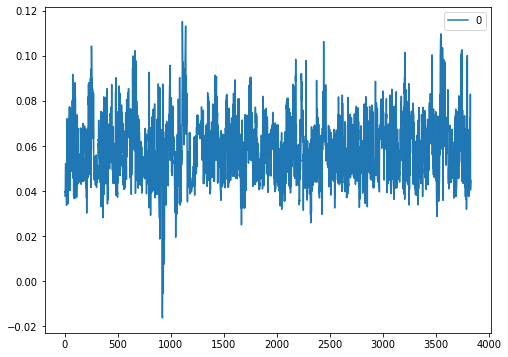

In [53]:
pd.DataFrame(x_pred).plot()

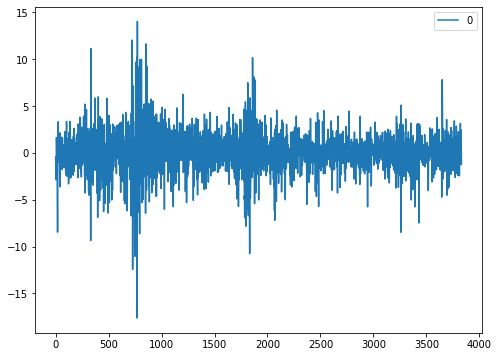

In [54]:
pd.DataFrame(y_train).plot()

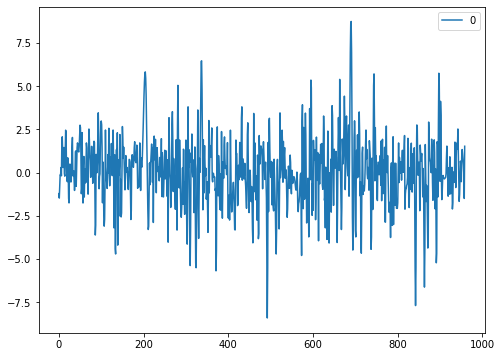

In [55]:
pd.DataFrame(y_test).plot()

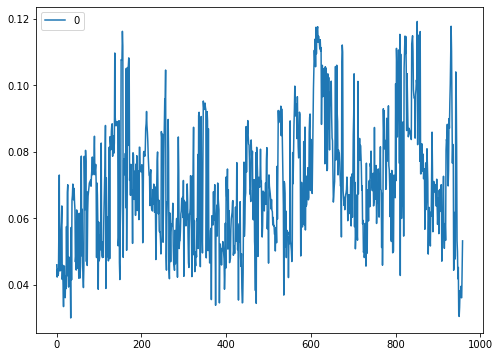

In [56]:
pd.DataFrame(y_pred).plot()

In [ ]:
#mse = h.history['mse']
#val_mse = h.history['val_mse']
loss = h.history['loss']
#val_loss = h.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs, mse, 'bo', label = 'Training mse')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation mse')
#plt.title('mse')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation loss')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(4040,), '-')
plt.plot(b_axis, y_pred.reshape(1011,), '-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(1011,), '-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

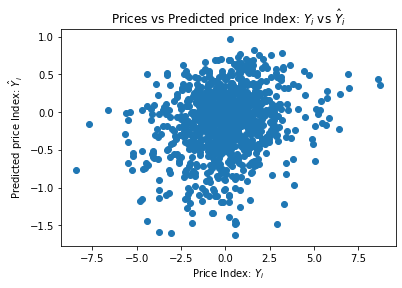

In [279]:
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")